In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import comb
from scipy.stats import norm

In [3]:
data_file = 'AMI_GSE66360_series_matrix.csv'

In [4]:
classes = list(pd.read_csv(data_file, low_memory=False, skiprows=58, nrows=1).iloc[0][1:])
set(classes)

{'H', 'M'}

In [5]:
df = pd.read_csv(data_file, index_col='ID_REF', skiprows=60)


In [6]:
df.sample(1)

,GSM1620819,GSM1620820,GSM1620821,GSM1620822,GSM1620823,GSM1620824,GSM1620825,GSM1620826,GSM1620827,GSM1620828,...,GSM1620908,GSM1620909,GSM1620910,GSM1620911,GSM1620912,GSM1620913,GSM1620914,GSM1620915,GSM1620916,GSM1620917
ID_REF,,,,,,,,,,,,,,,,,,,,,
1553876_at,9.023909,6.680498,7.155293,7.894541,7.350894,9.64827,8.231309,8.851079,7.76036,8.832757,...,7.701193,8.627725,8.476717,4.733247,6.21642,5.603843,7.060092,5.138193,5.79719,6.644111


### 3 - analysis

In [7]:
'Genes profiled {}'.format(df.shape[0])

'Genes profiled 54675'

In [8]:
'samples (subjects/patients) in total {}'.format(df.shape[1])

'samples (subjects/patients) in total 99'

In [9]:
num_of_m = len([c for c in  classes if c == 'M'])
num_of_h = len([c for c in  classes if c == 'H'])
'samples in each class M:{} H:{}'.format(num_of_m, num_of_h)

'samples in each class M:49 H:50'

#### remove na rows:

In [10]:
original_size = df.shape[0]
df.dropna(inplace=True)

'num of rows after drop {}'.format(df.shape[0])

'num of rows after drop 54628'

### Pick 20 genes at random

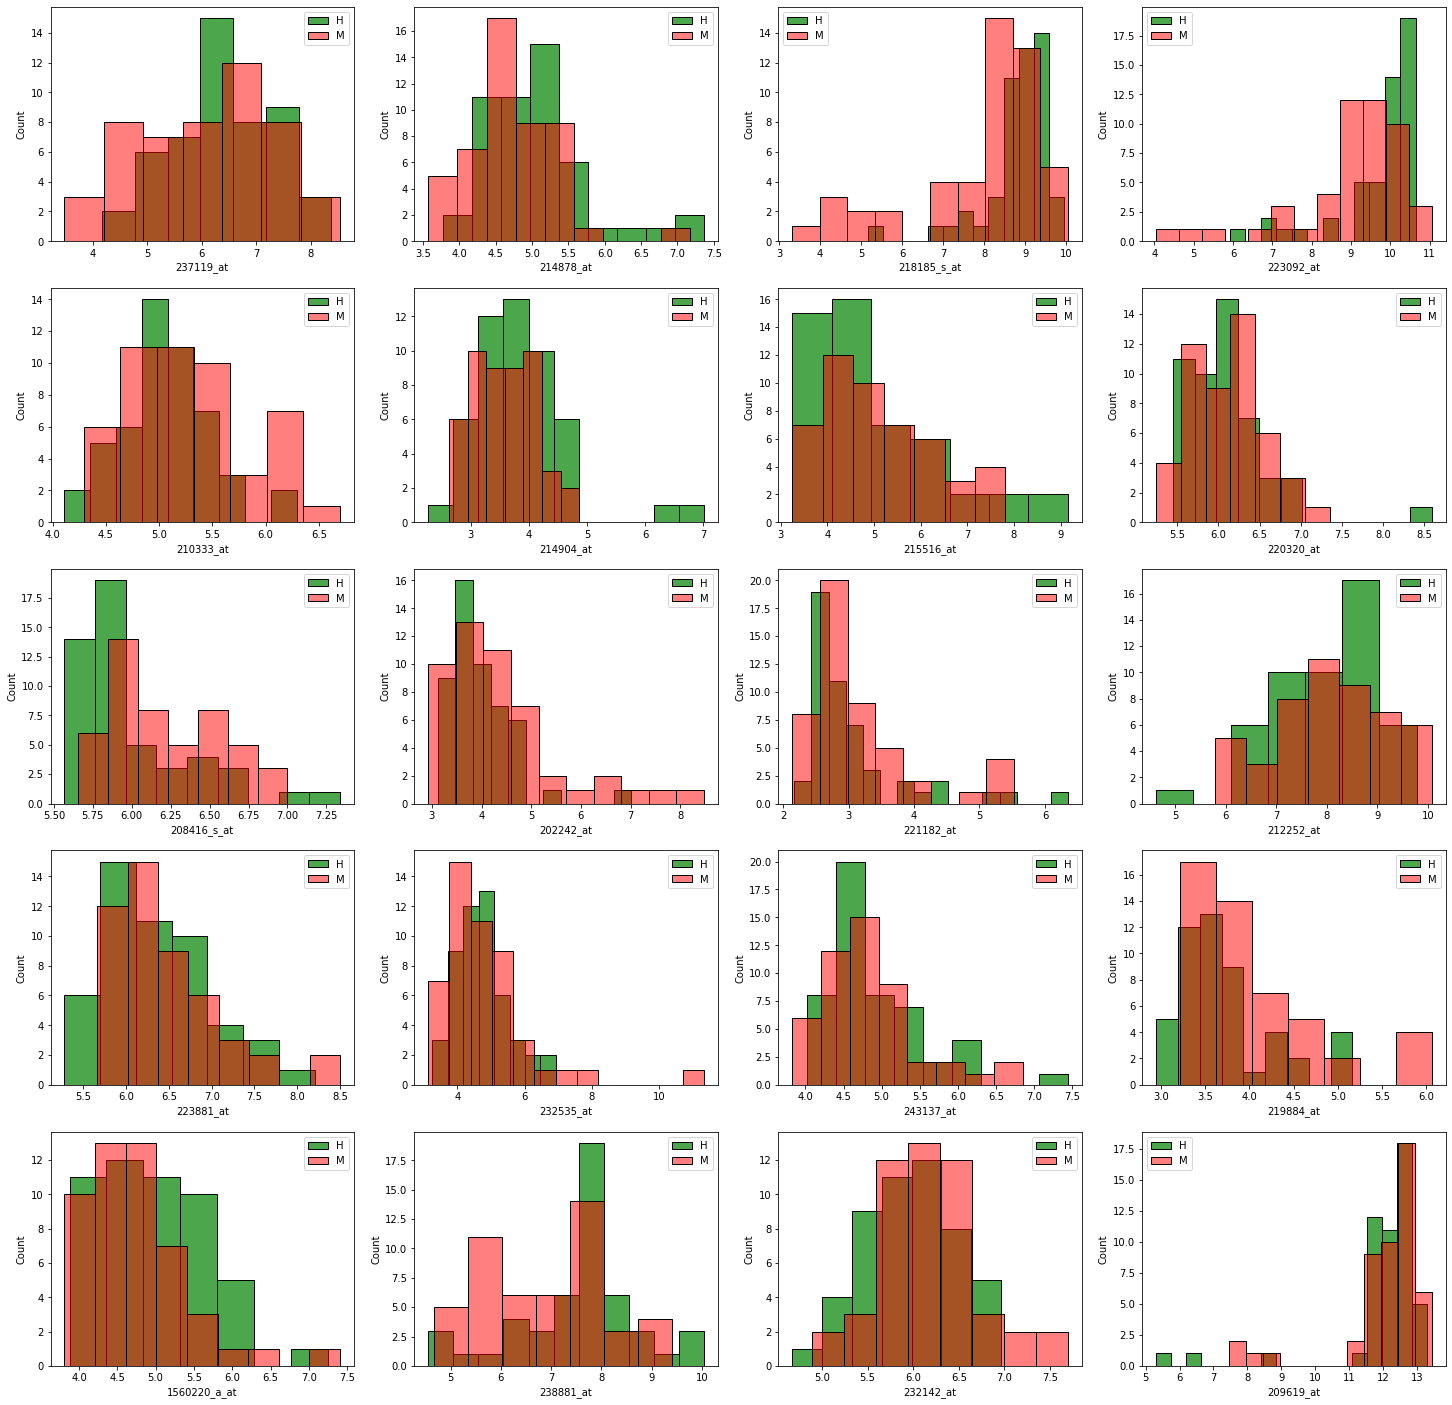

In [11]:
random_sample = df.sample(20)

random_sample.loc["Label"] = classes
random_sample = random_sample.T

h_samples = random_sample[random_sample['Label'] == 'H'].drop(['Label'], axis=1)
m_samples = random_sample[random_sample['Label'] == 'M'].drop(['Label'], axis=1)

genes = random_sample.columns
fig, axes = plt.subplots(5,4, figsize=(25,25))

for row in range(5):
    for column in range(4):
        gene = genes[(row*4)+column]
        sns.histplot(data=h_samples, x=gene, color="Green", alpha=0.7, label="H", ax=axes[row][column])
        sns.histplot(data=m_samples, x=gene, color="Red", alpha=0.5, label="M",ax=axes[row][column])
        axes[row][column].legend()
        


#### b.1

In [12]:
n = len(df.columns)
expected_sum_of_m_ranks = num_of_m * ((n+1)/2)

'The expected sum of M ranks for any gene g {}'.format(expected_sum_of_m_ranks)
# print(f"In our case, the expected sum of ranks for any given gene g is: {T}")


'The expected sum of M ranks for any gene g 2450.0'

### b.2

In [13]:
start = num_of_h + 1
'Max Number RS(g) can get is {}'.format(np.sum(range(start, start+ num_of_m)))

'Max Number RS(g) can get is 3675'

### b.3 

In [14]:
'1/num of combinations possibles {}'.format(1 / comb(n, num_of_m))

'1/num of combinations possibles 1.982330604283668e-29'

### b.4

The formula in b.3 in correct for any permutations meanning its the same probability for c, c-1, c-2 etc..

#### b.5

In [15]:
m_ranks_sums = []
for _, row in df.iterrows():
    
    ranks = stats.rankdata(row)
    rank_class_pairs = [(gene_rank, person_class) for (gene_rank, person_class) in zip(ranks, classes) ]
    
    m_rank_sum = np.sum([rank for (rank, person_class) in  rank_class_pairs if person_class == 'M'])
    m_ranks_sums.append(m_rank_sum)


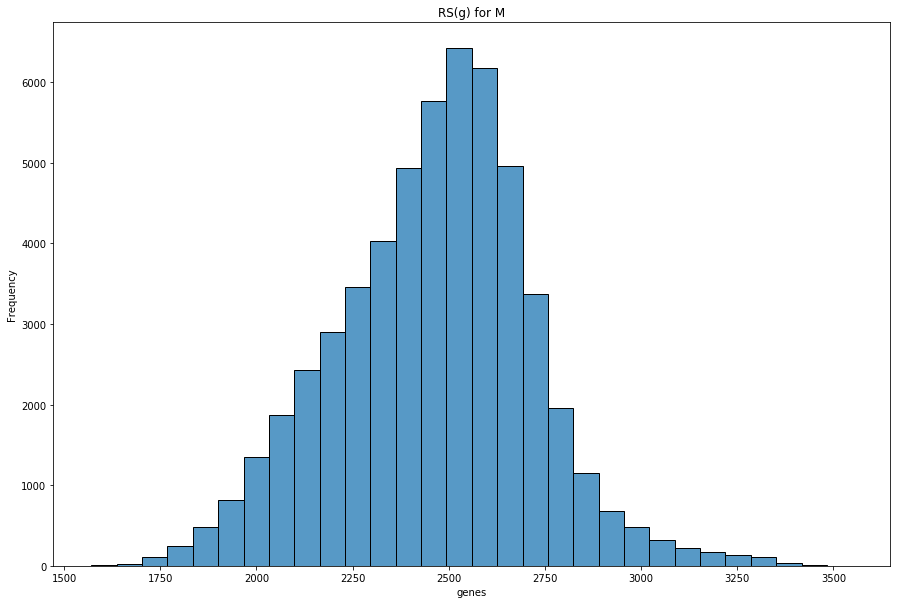

In [16]:
iqr = stats.iqr(ranks)
fig, axes = plt.subplots(1,1, figsize=(15,10))
sns.histplot(m_ranks_sums, bins=30, ax=axes)
plt.title('RS(g) for M')
plt.xlabel('genes');
plt.ylabel('Frequency');

#### c

In [17]:
p_threshold = 0.07

In [18]:
def wrs(ranks, mean, std, p_val):
    wrs_p = []
    overexpressed = 0
    underexpressed = 0

    for sum_rank in ranks:
        prob =  norm.cdf((sum_rank - mean) / std)
        wrs_p.append(prob)
        if prob <= p_val:
            overexpressed += 1
        elif prob >= (1-p_val):
            underexpressed +=1

    return wrs_p,overexpressed, underexpressed

In [19]:
mean = num_of_m * ((n)/2)
std = np.sqrt((num_of_m*(n + 1)*(n - num_of_h))/12)
wrs_p,overexpressed, underexpressed = wrs(m_ranks_sums, mean, std, p_threshold)

'WRS: num of overexpressed is {} | num of underexpressed is {}'.format(overexpressed, underexpressed)


'WRS: num of overexpressed is 9555 | num of underexpressed is 12875'

In [20]:
def ttest(df, classes, p_val):
    
    h_indices = [c == 'H' for c in classes]
    m_indices = [c == 'M' for c in classes]
    h_values = df.values[:, h_indices]
    m_values = df.values[:, m_indices]

    t_vals, p_vals = stats.ttest_ind(h_values, m_values, axis=1)
    
    signioficant_indices = np.argwhere(p_vals <= p_val).flatten()
    significant_df = df.iloc[signioficant_indices]
    significant_values = significant_df.values
    
    h_means = significant_values[:, h_indices].mean(axis=1)
    m_means = significant_values[:, m_indices].mean(axis=1)
    

    num_of_overexpressed = len(significant_values[m_means > h_means])
    num_of_undexpexpressed = len(significant_values[m_means < h_means])
            
    return p_vals, t_vals, num_of_overexpressed, num_of_undexpexpressed

ttest_p_vals, t_vals, num_of_overexpressed, num_of_undexpexpressed = ttest(df, classes, p_threshold)

In [21]:
"The number of overexpressed is {}, the number of underexpressed is {}".format(num_of_overexpressed, num_of_undexpexpressed)


'The number of overexpressed is 5860, the number of underexpressed is 6402'

### d

In [24]:
p_vals_col = pd.Series(wrs_p)
index_list = list(df.index)
df_new = df.reset_index()
df_new.drop(columns='ID_REF', inplace=True)


largest_pvals_indices = list(p_vals_col.sort_values(ascending=False).index[:80])
smallest_pvals_indices = list(p_vals_col.sort_values(ascending=True).index[:80])

d_indices = largest_pvals_indices + smallest_pvals_indices
D = [index_list[ind] for ind in d_indices]
significants_df = df.iloc[d_indices]

#### d.1

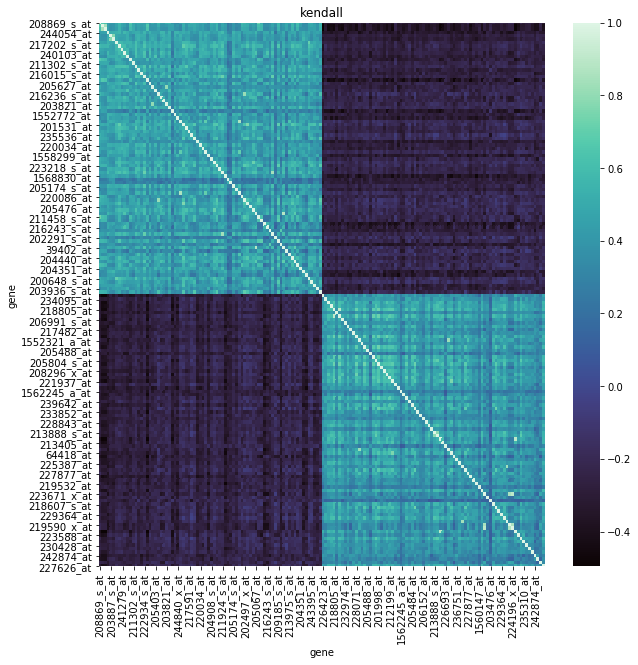

In [25]:
plt.figure(figsize=(10,10))
cor = significants_df.T.corr(method='kendall')
sns.heatmap(cor, cmap='mako')
plt.xlabel('gene')
plt.ylabel('gene')
plt.title('kendall');

#### d.2

In [26]:
'kendall mean {}'.format(np.mean(cor.values))

'kendall mean 0.09016181231892699'

### d.3

#### When gene is overexpressed in M it is underexpresses in H and the opposite.

#### d.5

Advantages:

More data to get insights,  maybe something is not significant with M or H but with other significant Gene.

Disadvantages:

Would insert noise to the data and reduce the focus from genes that we already know that are significants.



### d.6

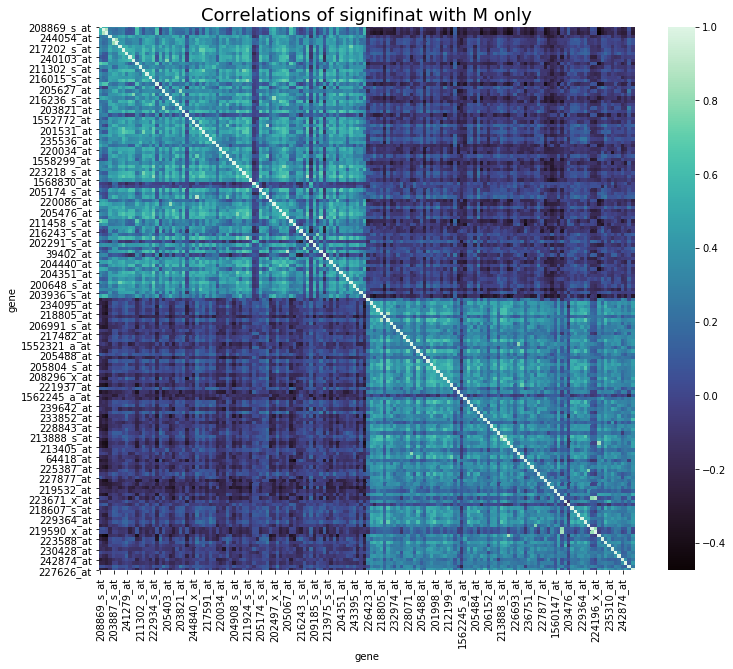

In [37]:
m_indiceas = np.array(classes) == 'M'
h_indiceas = np.array(classes) == 'H'

significant_m = pd.DataFrame(significants_df.values[:, m_indiceas], 
                                   index=significants_df.index,
                                   columns=significants_df.columns[m_indiceas])

plt.figure(figsize=(12,10))
sns.heatmap(significant_m.T.corr(method='kendall'), cmap='mako')
plt.title('Correlations of signifinat with M only', fontsize=18);
plt.xlabel('gene')
plt.ylabel('gene');

#### The M correlation is more similar to M+H than I thought.
#### The positive correlations are weaker than before.

#### e.1

In [29]:
wrs_p_values = np.array(wrs_p)

wrs_p_values_sorted_ind = wrs_p_values.argsort()
p_vals_wrs_sorted = wrs_p_values[wrs_p_values_sorted_ind]

fdr_wrs = p_vals_wrs_sorted * len(df) / np.arange(1, len(df)+1)

for fdr in [0.5, 0.1, 0.005]:
        print('Number of genes tfor FDR {} is {}'.format(fdr, 
                                                                          np.isclose(fdr_wrs, fdr, 
                                                                                      rtol=0.0002).sum()))

Number of genes tfor FDR 0.5 is 4
Number of genes tfor FDR 0.1 is 0
Number of genes tfor FDR 0.005 is 0


In [30]:
p_vals_ttest_sorted_ind = ttest_p_vals.argsort()
p_vals_ttest_sorted = ttest_p_vals[p_vals_ttest_sorted_ind]


ttest_fdr = p_vals_ttest_sorted * len(df) / np.arange(1, len(df)+1)

for fdr in [0.5, 0.1, 0.005]:
     print('Number of genes for fdr {} is {}'.format(fdr, np.isclose(ttest_fdr, fdr, rtol=0.0002).sum()))

Number of genes for fdr 0.5 is 4
Number of genes for fdr 0.1 is 1
Number of genes for fdr 0.005 is 0


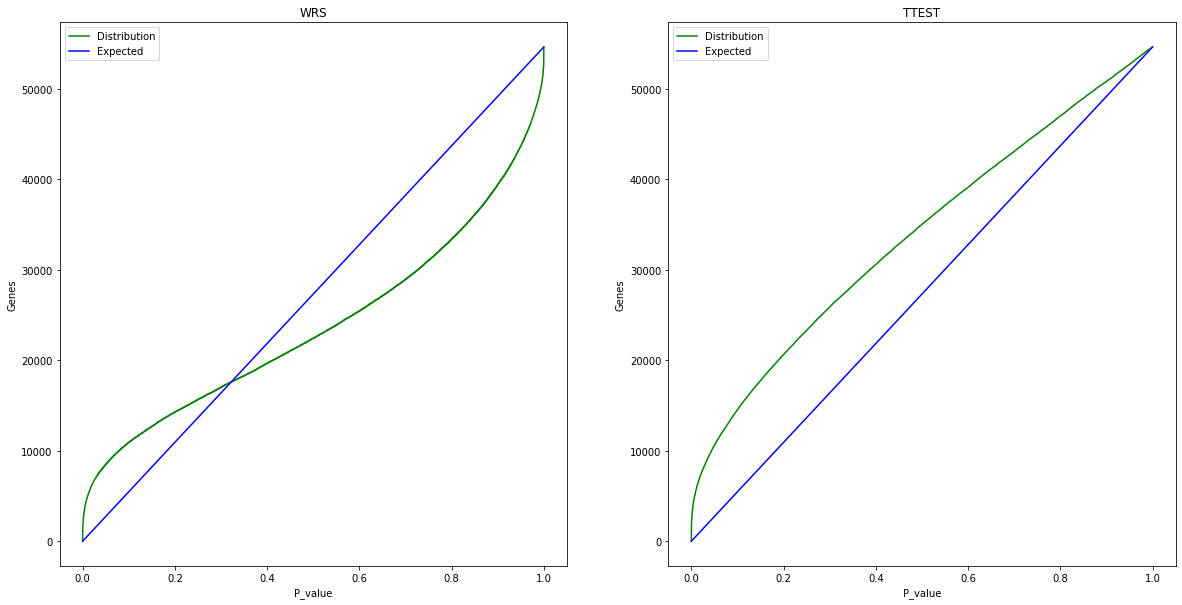

In [32]:

y = np.arange(1, len(df)+1)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(p_vals_wrs_sorted, y, label='Distribution', color="green")
axes[0].plot(np.linspace(0,1), np.linspace(0,len(df)), label='Expected', color="blue")
axes[0].set(xlabel='P_value', ylabel='Genes')
axes[0].set_title('WRS')
axes[0].legend();

axes[1].plot(p_vals_ttest_sorted, y, label='Distribution', color="green")
axes[1].plot(np.linspace(0,1), np.linspace(0,len(df)), label='Expected', color="blue")
axes[1].set(xlabel='P_value', ylabel='Genes')
axes[1].set_title('TTEST')
axes[1].legend()

### e.2

In [34]:
random_3_most_sig_genes_df = significants_df.sample(n=3)

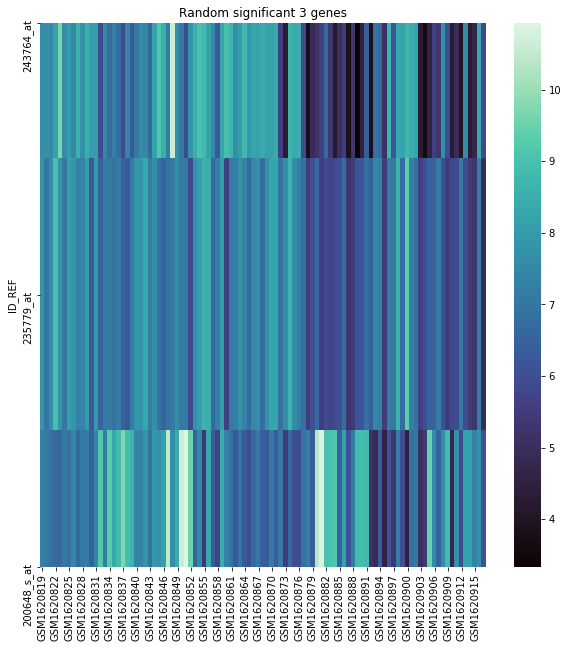

In [35]:
plt.figure(figsize=(10,10))
plt.title('Random significant 3 genes')
sns.heatmap(random_3_most_sig_genes_df, cmap='mako');

### e.3

In [39]:
M_df = significants_df.iloc[:,np.argwhere(m_indiceas).flatten()]
H_df =  significants_df.iloc[:,np.argwhere(h_indiceas).flatten()]
sorted_df = pd.concat([M_df, H_df], axis=1)

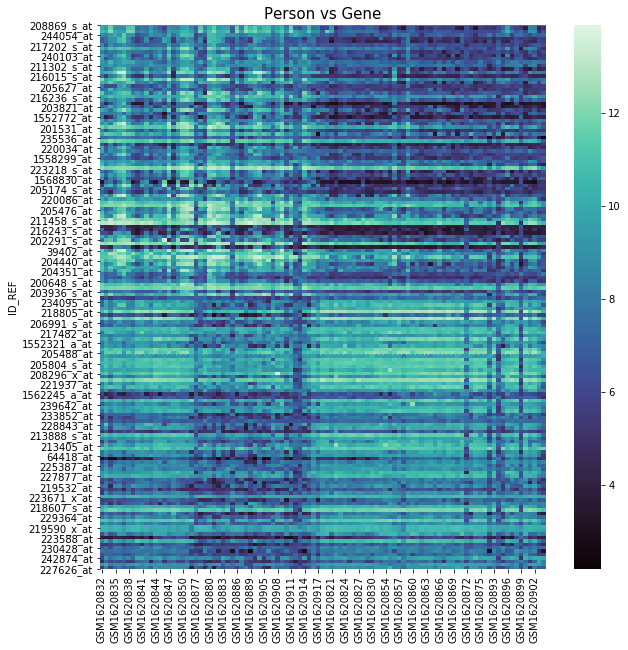

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(sorted_df, cmap='mako')
plt.title('Person vs Gene', fontsize=15);